## NREL WIND Toolkit - Validation Demo

This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) Wind Integration National Dataset (WIND) Toolkit data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

For this to work you must first install h5pyd:

```
pip install --user git+http://github.com/HDFGroup/h5pyd.git
```

Then, you can make a configuration file at ~/.hscfg with contents like so:

```
# HDFCloud configuration file
hs_endpoint = https://developer.nrel.gov/api/hsds/
hs_username = None
hs_password = None
hs_api_key = 3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf
```

*The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/*

In [98]:
%matplotlib inline
from collections import OrderedDict
import h5pyd
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyproj import Proj

sns.set_style("white")
sns.set_style("ticks")

def indicesForCoord(f, lat_index, lon_index):
    """
    Function to find the nearest x/y indicces for a given lat/lon using Proj4 projection library
    
    Parameters
    ----------
    f : 'h5pyd.File'
        h5pyd File instance for the database
    lat_index : 'float'
        Latitude of coordinate of interest
    lon_index : 'float'
        Longitude of coordinate of interest
        
    Results
    -------
    ij : 'tuple'
        x/y coordinate in the database of the closest pixel to coordinate of interest
    """
    dset_coords = f['coordinates']
    projstring = """+proj=lcc +lat_1=30 +lat_2=60 
                    +lat_0=38.47240422490422 +lon_0=-96.0 
                    +x_0=0 +y_0=0 +ellps=sphere 
                    +units=m +no_defs """
    projectLcc = Proj(projstring)
    origin_ll = reversed(dset_coords[0][0])  # Grab origin directly from database
    origin = projectLcc(*origin_ll)
    
    coords = (lon_index, lat_index)
    coords = projectLcc(*coords)
    delta = np.subtract(coords, origin)
    ij = [int(round(x/2000)) for x in delta]
    return tuple(reversed(ij))

[DIF](#Diffuse-Horizontal-Irradiance) | [DNI](#Direct-Normal-Irradiance) | [Temp](#Surface-Temperature) | [WSPD](#Surface-Wind-Speed)

## Compare NSRDB to WIND Toolkit
### NSRDB Site
Several sites were randomly selected from the NSRDB  
Sites were chosen from different states with in the continental United States

In [160]:
nsrdb =  h5py.File('nsrdb_samples.h5', 'r')
list(nsrdb)

['meta',
 'site_1147204',
 'site_1196412',
 'site_683838',
 'site_703836',
 'time_index']

In [161]:
nsrdb_sites = pd.DataFrame(nsrdb['meta'][...])
nsrdb_sites

,latitude,longitude,elevation,timezone,country,state,county,urban,population,landcover,gid
0,45.57,-96.18,351.44,-6,b'United States',b'Minnesota',b'Stevens',b'None',401,140,703836
1,36.29,-76.58,12.00,-5,b'United States',b'North Carolina',b'Chowan',b'None',97,50,1147204
2,43.33,-97.02,391.15,-6,b'United States',b'South Dakota',b'Turner',b'None',14,140,683838
3,41.01,-75.10,187.80,-5,b'United States',b'New Jersey',b'Monroe',b'None',465,50,1196412


Hourly irradiance, temperature, and wind speed was extracted for 2007-2013

In [162]:
site_id = 683838
site_pos = nsrdb_sites['gid'] == site_id
site_lat_lon = nsrdb_sites.loc[site_pos, ['latitude', 'longitude']].values[0]
site_tz = nsrdb_sites.loc[site_pos, 'timezone'].item()
print('NSRDB site {:} coordinates = '.format(site_id), site_lat_lon)

dt = pd.to_datetime(nsrdb['time_index'][:].astype(str))
site_ds = pd.DataFrame(nsrdb['site_{:}'.format(site_id)][...],
                       index=dt)

site_ds.head()

NSRDB site 683838 coordinates =  [ 43.33 -97.02]


,dhi,dni,surface_temperature,wspd
2007-01-01 00:00:00,0.0,0.0,266.52,8.18
2007-01-01 01:00:00,0.0,0.0,265.74,7.86
2007-01-01 02:00:00,0.0,0.0,264.98,7.38
2007-01-01 03:00:00,0.0,0.0,264.12,6.83
2007-01-01 04:00:00,0.0,0.0,263.22,6.35


In [163]:
nsrdb.close()

### Nearest WIND Toolkit Site

In [164]:
wtk = h5pyd.File("/nrel/wtk-us.h5", 'r')

Find nearest WIND Toolkit site

In [165]:
wtk_ij = indicesForCoord(wtk, *site_lat_lon)

wtk_lat_lon = wtk['coordinates'][wtk_ij[0], wtk_ij[1]]
print('WTK nearest site coordinates = ', wtk_lat_lon)

WTK nearest site coordinates =  ( 43.340008, -97.010956)


Extract the same variables present in NSRDB

In [166]:
dt = pd.to_datetime(wtk['datetime'][:].astype(str))
wtk_ds = OrderedDict()
for var in ['DIF', 'DNI', 'temperature_2m', 'windspeed_10m']:
    wtk_ds[var] = wtk[var][:, wtk_ij[0], wtk_ij[1]]
    
wtk_ds = pd.DataFrame(wtk_ds, index=dt)
wtk_ds.head()

,DIF,DNI,temperature_2m,windspeed_10m
2007-01-01 00:00:00,0.0,0.0,269.638672,9.674370
2007-01-01 01:00:00,0.0,0.0,269.574585,9.747612
2007-01-01 02:00:00,0.0,0.0,269.183929,8.816795
2007-01-01 03:00:00,0.0,0.0,269.019135,8.523819
2007-01-01 04:00:00,0.0,0.0,268.625458,8.307137


In [167]:
wtk.close()

### Comparison

In [194]:
nsrdb_comp = site_ds.copy()
nsrdb_comp.columns = ['DIF', 'DNI', 'Temperature', 'Wind Speed']
nsrdb_comp['dataset'] = 'NSRDB'

wtk_comp = wtk_ds.copy()
wtk_comp.columns = ['DIF', 'DNI', 'Temperature', 'Wind Speed']
wtk_comp['dataset'] = 'WTK'

comp_ds = pd.concat([nsrdb_comp, wtk_comp])
comp_ds['year'] = comp_ds.index.year
comp_ds['month'] = comp_ds.index.month
# Shift hour to local time
comp_ds['hour'] = (comp_ds.index + pd.to_timedelta('{:}h'.format(site_tz))).hour

#### Diffuse Horizontal Irradiance

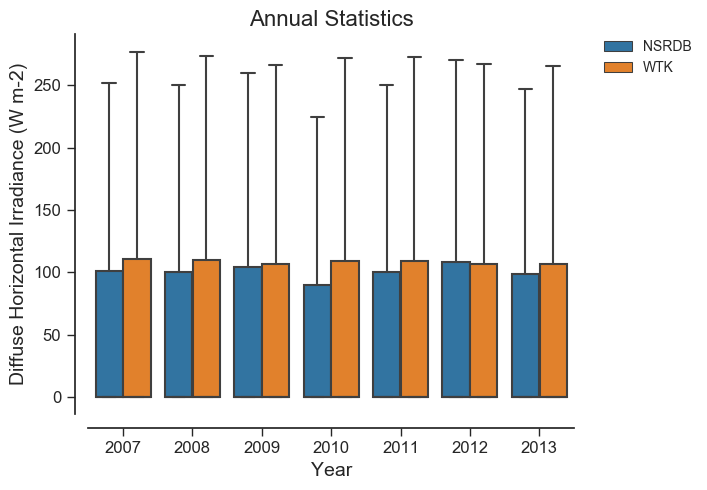

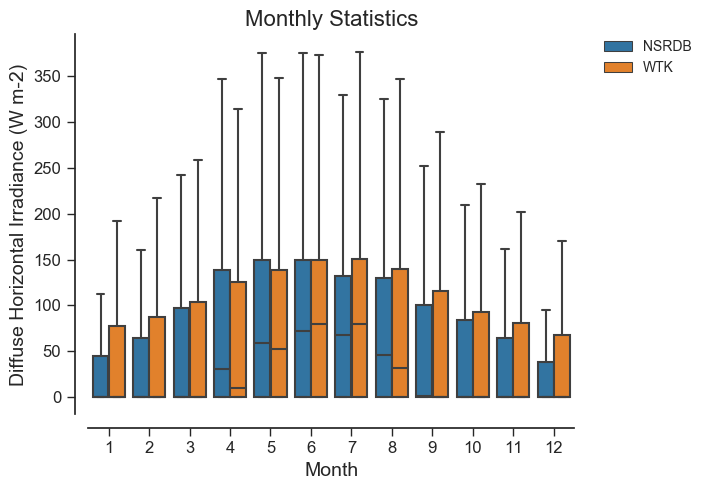

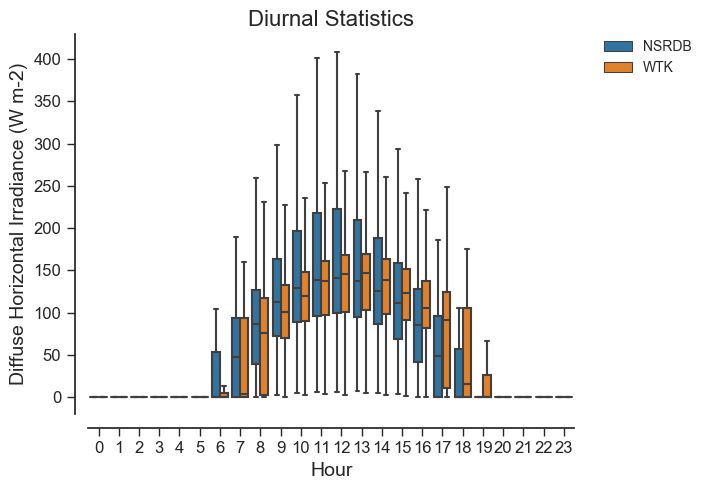

In [202]:
variable = 'DIF'
label = 'Diffuse Horizontal Irradiance (W m-2)'

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=comp_ds,
           showfliers=False, ax=axis)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

#### Direct Normal Irradiance

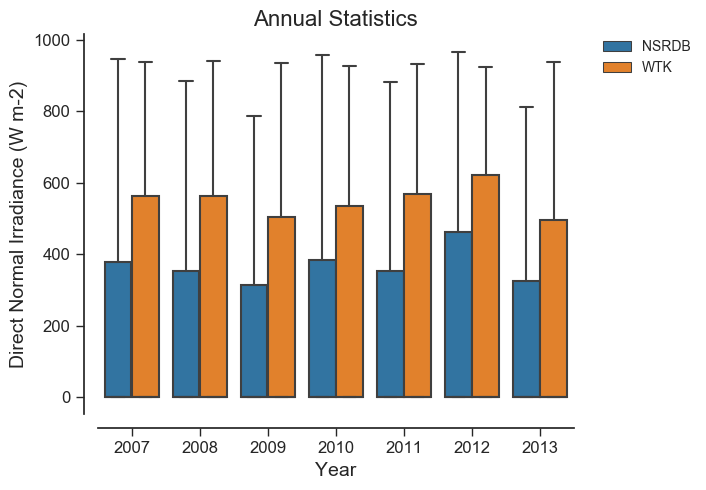

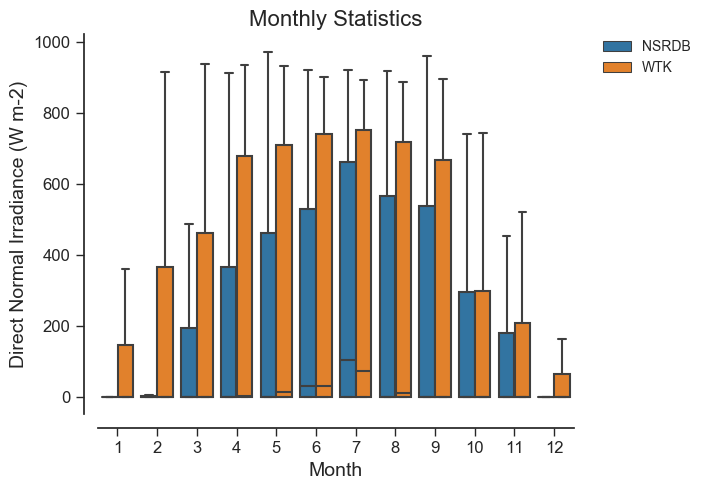

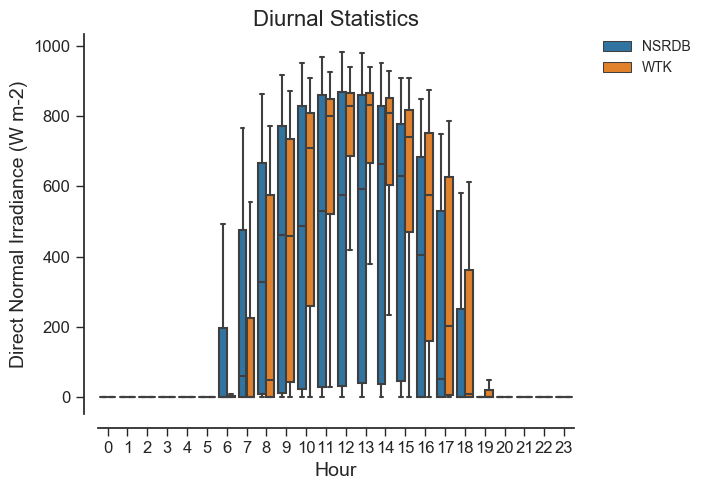

In [201]:
variable = 'DNI'
label = 'Direct Normal Irradiance (W m-2)'

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=comp_ds,
           showfliers=False, ax=axis)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

#### Surface Temperature

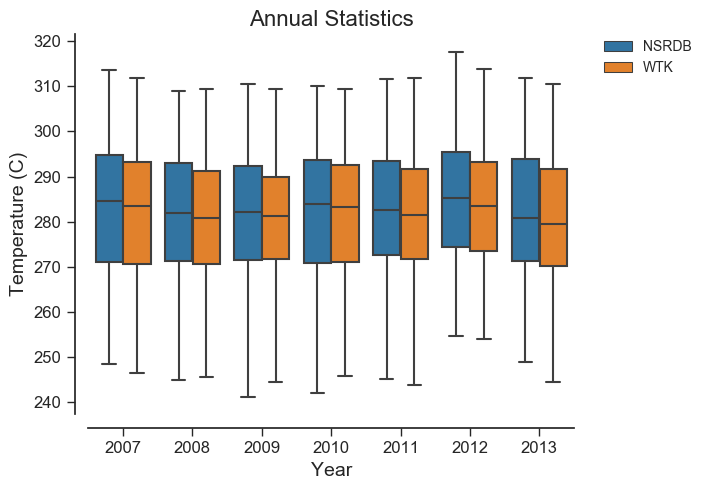

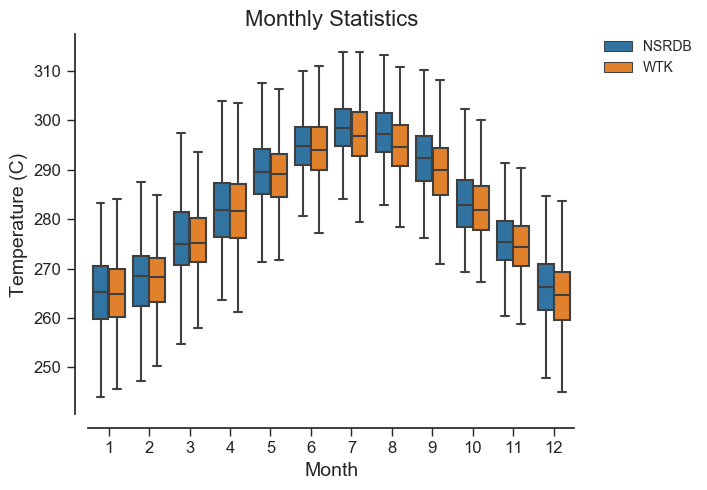

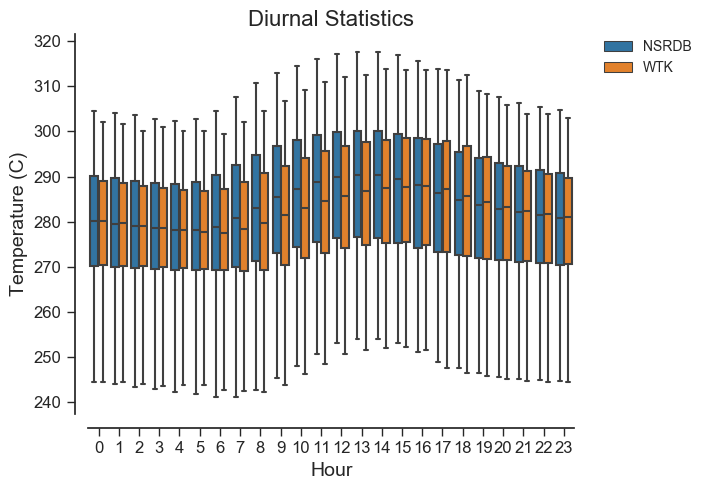

In [203]:
variable = 'Temperature'
label = 'Temperature (C)'

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=comp_ds,
           showfliers=False, ax=axis)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

#### Surface Wind Speed

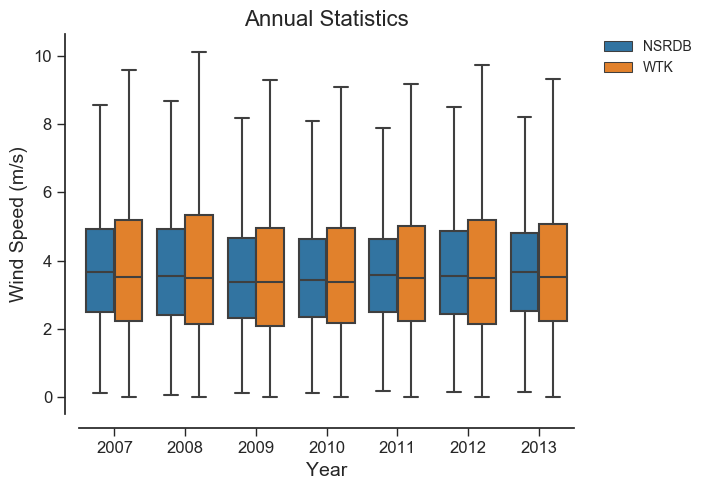

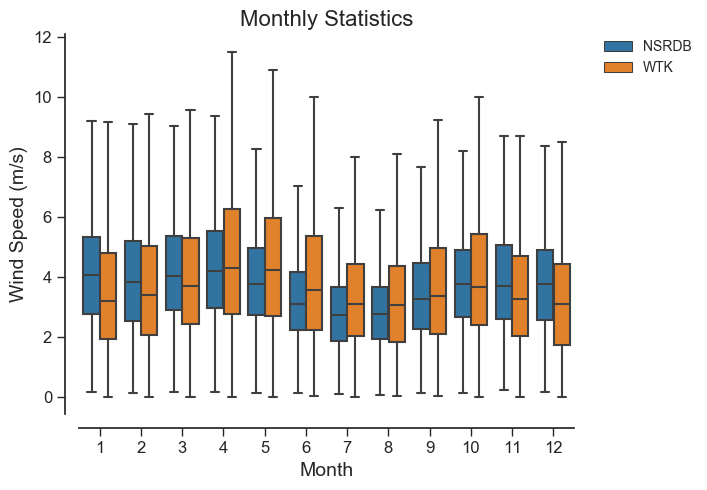

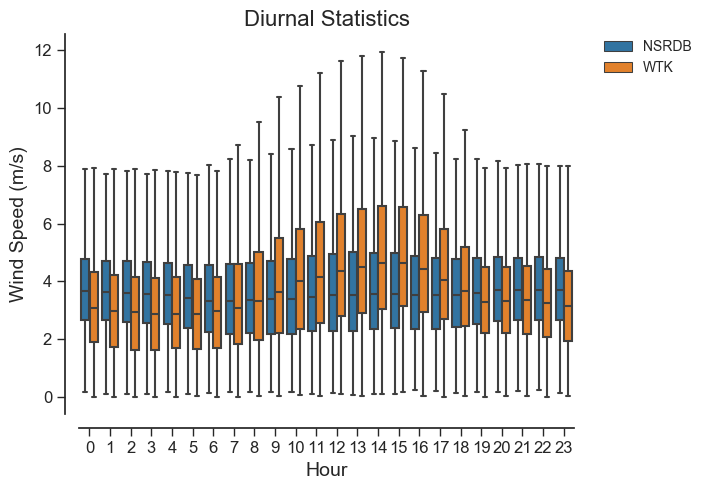

In [204]:
variable = 'Wind Speed'
label = 'Wind Speed (m/s)'

fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Annual Statistics', fontsize=16)
sns.boxplot(x='year', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Year', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Monthly Statistics', fontsize=16)
sns.boxplot(x='month', y=variable, hue='dataset', data=comp_ds,
            showfliers=False, ax=axis)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Month', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()


fig = plt.figure(figsize=(6,5), dpi=100)
axis = fig.add_subplot(111)
axis.set_title('Diurnal Statistics', fontsize=16)
sns.boxplot(x='hour', y=variable, hue='dataset', data=comp_ds,
           showfliers=False, ax=axis)
sns.despine(offset=10, trim=False)
axis.set_xlabel('Hour', fontsize=14)
axis.set_ylabel(label, fontsize=14)

axis.tick_params(axis='x', labelsize=12, width=1, length=6)
axis.tick_params(axis='y', labelsize=12, width=1, length=6)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()